<a href="https://colab.research.google.com/github/pachterlab/CWGFLHGCCHAP_2021/blob/master/notebooks/SearchAndPlotInteractive/MARIMBAAnnosAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Download Data**

In [ ]:
#Install kallisto and bustools

!wget --quiet https://github.com/pachterlab/kallisto/releases/download/v0.46.2/kallisto_linux-v0.46.2.tar.gz
!tar -xf kallisto_linux-v0.46.2.tar.gz
!cp kallisto/kallisto /usr/local/bin/

!wget --quiet https://github.com/BUStools/bustools/releases/download/v0.40.0/bustools_linux-v0.40.0.tar.gz
!tar -xf bustools_linux-v0.40.0.tar.gz
!cp bustools/bustools /usr/local/bin/

In [ ]:
import requests
from tqdm import tnrange, tqdm_notebook
def download_file(doi,ext):
    url = 'https://api.datacite.org/dois/'+doi+'/media'
    r = requests.get(url).json()
    netcdf_url = r['data'][0]['attributes']['url']
    r = requests.get(netcdf_url,stream=True)
    #Set file name
    fname = doi.split('/')[-1]+ext
    #Download file with progress bar
    if r.status_code == 403:
        print("File Unavailable")
    if 'content-length' not in r.headers:
        print("Did not get file")
    else:
        with open(fname, 'wb') as f:
            total_length = int(r.headers.get('content-length'))
            pbar = tnrange(int(total_length/1024), unit="B")
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    pbar.update()
                    f.write(chunk)
        return fname

In [ ]:
#Get reference data (transcripts, transcriptome gff, fastq's)

#Transcripts fasta (Marimba)
download_file('10.22002/D1.1829','.gz')

#Gff3 (Marimba)
download_file('10.22002/D1.1830','.gz')



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


'D1.1830.gz'

In [ ]:
#Get TRINITY analyzed starvation data (with clustering,embedding etc)
download_file('10.22002/D1.1796','.gz')

#Raw starvation data (all nonzero genes included)
download_file('10.22002/D1.1797','.gz')

#Neurons data
download_file('10.22002/D1.1804','.gz')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


'D1.1804.gz'

In [ ]:
#Raw Marimba-processed data
download_file('10.22002/D1.1832','.gz')

#Marimba filtered/clustered data
download_file('10.22002/D1.1833','.gz')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


'D1.1833.gz'

In [ ]:
# Get doi links for all Starvation cDNA fastq.gz files
starvFiles = []
dois = ['10.22002/D1.1840','10.22002/D1.1841','10.22002/D1.1842','10.22002/D1.1843',
        '10.22002/D1.1844','10.22002/D1.1845','10.22002/D1.1846','10.22002/D1.1847',
        '10.22002/D1.1848','10.22002/D1.1849','10.22002/D1.1850','10.22002/D1.1851',
        '10.22002/D1.1852','10.22002/D1.1853','10.22002/D1.1854','10.22002/D1.1855'] #16 doi numbers
for doi in dois:
  url = 'https://api.datacite.org/dois/'+doi+'/media'
  r = requests.get(url).json()
  netcdf_url = r['data'][0]['attributes']['url']

  starvFiles += [netcdf_url]

s1 = starvFiles[0]
s2 = starvFiles[1]
s3 = starvFiles[2]
s4 = starvFiles[3]
s5 = starvFiles[4]
s6 = starvFiles[5]
s7 = starvFiles[6]
s8 = starvFiles[7]

s9 = starvFiles[8]
s10 = starvFiles[9]
s11 = starvFiles[10]
s12 = starvFiles[11]
s13 = starvFiles[12]
s14 = starvFiles[13]
s15 = starvFiles[14]
s16 = starvFiles[15]

In [ ]:
!gunzip *.gz

In [ ]:
!pip install --quiet anndata
!pip install --quiet scanpy
!pip install --quiet louvain

     |████████████████████████████████| 122kB 5.8MB/s 
     |████████████████████████████████| 7.7MB 4.1MB/s 
     |████████████████████████████████| 71kB 9.0MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 2.2MB 5.7MB/s 
     |████████████████████████████████| 3.2MB 28.4MB/s 


### **Import Packages**

In [ ]:
import pandas as pd
import anndata
import scanpy as sc
import numpy as np
import scipy.sparse

import matplotlib.pyplot as plt
%matplotlib inline
sc.set_figure_params(dpi=125)

### **Run kallisto bus on data with MARIMBA annotation**

In [ ]:
#Make Kallisto index (reference https://www.kallistobus.tools/getting_started)
!mv D1.1829 transcripts.fa
!kallisto index -i cufflinksTrans_clytia.idx -k 31 transcripts.fa

mv: cannot stat 'D1.1829': No such file or directory

[build] loading fasta file transcripts.fa
[build] k-mer length: 31
[build] warning: clipped off poly-A tail (longer than 10)
        from 16 target sequences
[build] warning: replaced 40896 non-ACGUT characters in the input sequence
        with pseudorandom nucleotides
[build] counting k-mers ... tcmalloc: large alloc 1610612736 bytes == 0x6d5f0000 @  0x7f19fcbbb1e7 0x6f46bd 0x6f4739 0x4af899 0x4a7a68 0x4aec09 0x44e175 0x7f19fbbd7bf7 0x452f19
done.
[build] building target de Bruijn graph ...  done 
[build] creating equivalence classes ...  done
[build] target de Bruijn graph has 489912 contigs and contains 58668462 k-mers 



Run kallisto for one set of samples

In [ ]:
#Create BUS files from fastq's, can't do separate lines
!mkfifo R1.gz R2.gz R1_02.gz R2_02.gz R1_03.gz R2_03.gz R1_04.gz R2_04.gz; curl -Ls $s1 > R1.gz & curl -Ls $s2 > R2.gz & curl -Ls $s3 > R1_02.gz & curl -Ls $s4 > R2_02.gz & curl -Ls $s5 > R1_03.gz & curl -Ls $s6 > R2_03.gz & curl -Ls $s7 > R1_04.gz & curl -Ls $s8 > R2_04.gz & kallisto bus -i cufflinksTrans_clytia.idx -o bus_output/ -x 10xv2 -t 2 R1.gz R2.gz R1_02.gz R2_02.gz R1_03.gz R2_03.gz R1_04.gz R2_04.gz 


In [ ]:
#Generate gene-count matrices
!wget --quiet https://github.com/bustools/getting_started/releases/download/getting_started/10xv2_whitelist.txt

#Make t2g file
!mv D1.1830 Marimba_merged_transcript_models.gff3
!awk '$3=="transcript"' Marimba_merged_transcript_models.gff3| awk '{ print $9}' > t2g_unsplit.txt
!sed 's/[ID=Parent]//g' t2g_unsplit.txt > t2g_clean.txt
!tr ';' '\t' < t2g_clean.txt  > t2g.txt




In [ ]:
#!cd bus_output/
!mkdir bus_output/genecount/ bus_output/tmp/

!bustools correct -w 10xv2_whitelist.txt -p bus_output/output.bus | bustools sort -T bus_output/tmptmp/ -t 2 -p - | bustools count -o bus_output/genecount/genes -g t2g.txt -e bus_output/matrix.ec -t bus_output/transcripts.txt --genecounts -

In [ ]:
# !ls test

Run kallisto for other sample set

In [ ]:
#Create BUS files from fastq's
!mkfifo R1_new.gz R2_new.gz R1_02_new.gz R2_02_new.gz R1_03_new.gz R2_03_new.gz R1_04_new.gz R2_04_new.gz; curl -Ls $s9 > R1_new.gz & curl -Ls $s10 > R2_new.gz & curl -Ls $s11 > R1_02_new.gz & curl -Ls $s12 > R2_02_new.gz & curl -Ls $s13 > R1_03_new.gz & curl -Ls $s14 > R2_03_new.gz & curl -Ls $s15 > R1_04_new.gz & curl -Ls $s16 > R2_04_new.gz & kallisto bus -i cufflinksTrans_clytia.idx -o bus_output_02/ -x 10xv2 -t 2 R1_new.gz R2_new.gz R1_02_new.gz R2_02_new.gz R1_03_new.gz R2_03_new.gz R1_04_new.gz R2_04_new.gz 

In [ ]:
#Generate gene-count matrices
!cd bus_output_02/
!mkdir bus_output_02/genecount/ bus_output_02/tmp/

!bustools correct -w 10xv2_whitelist.txt -p bus_output_02/output.bus | bustools sort -T bus_output_02/tmp/ -t 2 -p - | bustools count -o bus_output_02/genecount/genes -g t2g.txt -e bus_output_02/matrix.ec -t bus_output_02/transcripts.txt --genecounts -

Merge matrices (Add -1 to first and -2 to second dataset)

In [ ]:
path = "bus_output/genecount/"
jelly_adata_01 = sc.read(path+'genes.mtx', cache=True)
jelly_adata_01.var_names = pd.read_csv(path+'genes.genes.txt', header=None)[0]
jelly_adata_01.obs_names = pd.read_csv(path+'genes.barcodes.txt', header=None)[0]

jelly_adata_01.obs_names = [i+"-1" for i in jelly_adata_01.obs_names]

In [ ]:
path = "bus_output_02/genecount/"
jelly_adata_02 = sc.read(path+'genes.mtx', cache=True)
jelly_adata_02.var_names = pd.read_csv(path+'genes.genes.txt', header=None)[0]
jelly_adata_02.obs_names = pd.read_csv(path+'genes.barcodes.txt', header=None)[0]

jelly_adata_02.obs_names = [i+"-2" for i in jelly_adata_02.obs_names]

In [ ]:
jelly_adata = jelly_adata_01.concatenate(jelly_adata_02,join='outer', index_unique=None)

In [ ]:
jelly_adata.write('cuff_adata_unfilt.h5ad')

### **Read in saved dataset**

In [ ]:
#bus_fs_combo
bus_fs_trin = anndata.read("D1.1796")
bus_fs_raw_trin = anndata.read("D1.1797")

#Read in jelly_adata saved
jelly_adata = anndata.read("D1.1832")

In [ ]:
jelly_adata_filt = jelly_adata[list(bus_fs_trin.obs_names),:]
jelly_adata_filt

View of AnnData object with n_obs × n_vars = 13673 × 45872
    obs: 'batch'

In [ ]:
jelly_adata_filt.obs['orgID'] = pd.Categorical(bus_fs_trin.obs['orgID'])
jelly_adata_filt.obs['fed'] = pd.Categorical(bus_fs_trin.obs['fed'])
jelly_adata_filt.obs['starved'] = pd.Categorical(bus_fs_trin.obs['starved'])
jelly_adata_filt.obs['cellRanger_louvain'] = pd.Categorical(bus_fs_trin.obs['cellRanger_louvain'])

Trying to set attribute `.obs` of view, copying.


In [ ]:
sc.pp.filter_cells(jelly_adata_filt, min_counts=0) #1
sc.pp.filter_genes(jelly_adata_filt, min_counts=0)
jelly_adata_filt.obs['n_countslog']=np.log10(jelly_adata_filt.obs['n_counts'])

jelly_adata_filt.raw = sc.pp.log1p(jelly_adata_filt, copy=True)
sc.pp.normalize_per_cell(jelly_adata_filt, counts_per_cell_after=1e4)
filter_result = sc.pp.filter_genes_dispersion(
    jelly_adata_filt.X, min_mean=0.0125, max_mean=4.5, min_disp=0.2)
sc.pl.filter_genes_dispersion(filter_result)


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [ ]:
jelly_adata_filt = jelly_adata_filt[:, filter_result.gene_subset]
sc.pp.scale(jelly_adata_filt, max_value=10)
sc.tl.pca(jelly_adata_filt, n_comps=60)
jelly_adata_filt

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 13673 × 9609
    obs: 'batch', 'orgID', 'fed', 'starved', 'cellRanger_louvain', 'n_counts', 'n_countslog'
    var: 'n_counts', 'mean', 'std'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

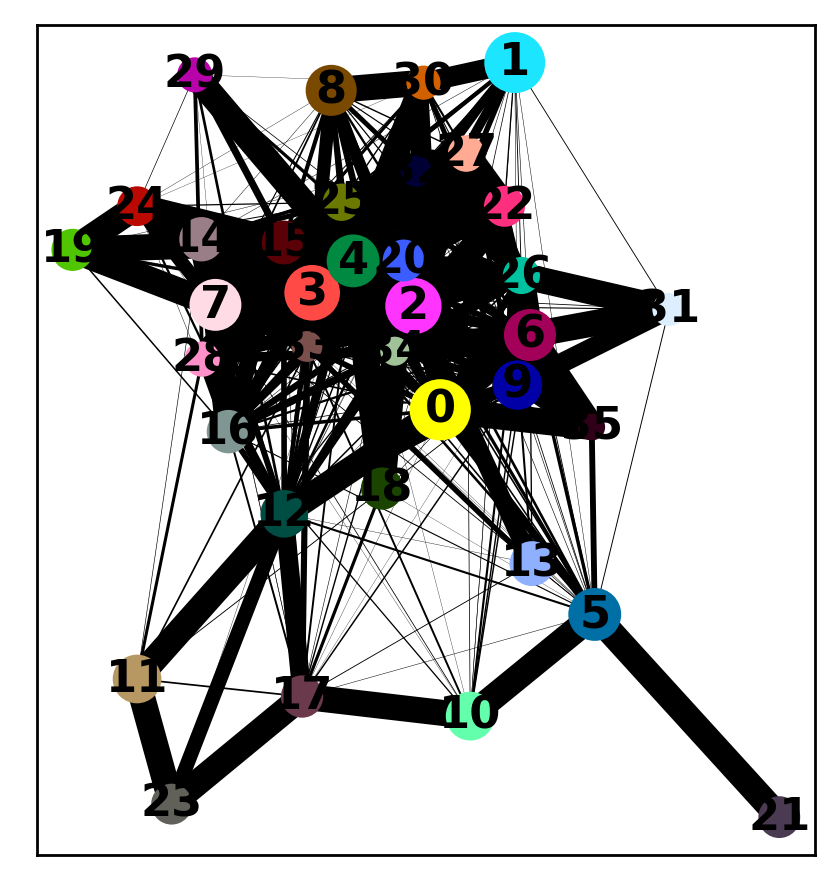

In [ ]:

sc.pp.neighbors(jelly_adata_filt,n_neighbors=150, n_pcs=60,random_state=42) #use_rep='X_nca'
sc.tl.paga(jelly_adata_filt, groups='cellRanger_louvain',)
sc.pl.paga(jelly_adata_filt, color=['cellRanger_louvain'])

sc.tl.umap(jelly_adata_filt,random_state=42,spread=2.5,min_dist = 0.8,init_pos='paga')

In [ ]:
sc.tl.umap(jelly_adata_filt,random_state=42,spread=3.5,min_dist = 1.5,init_pos='paga')

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


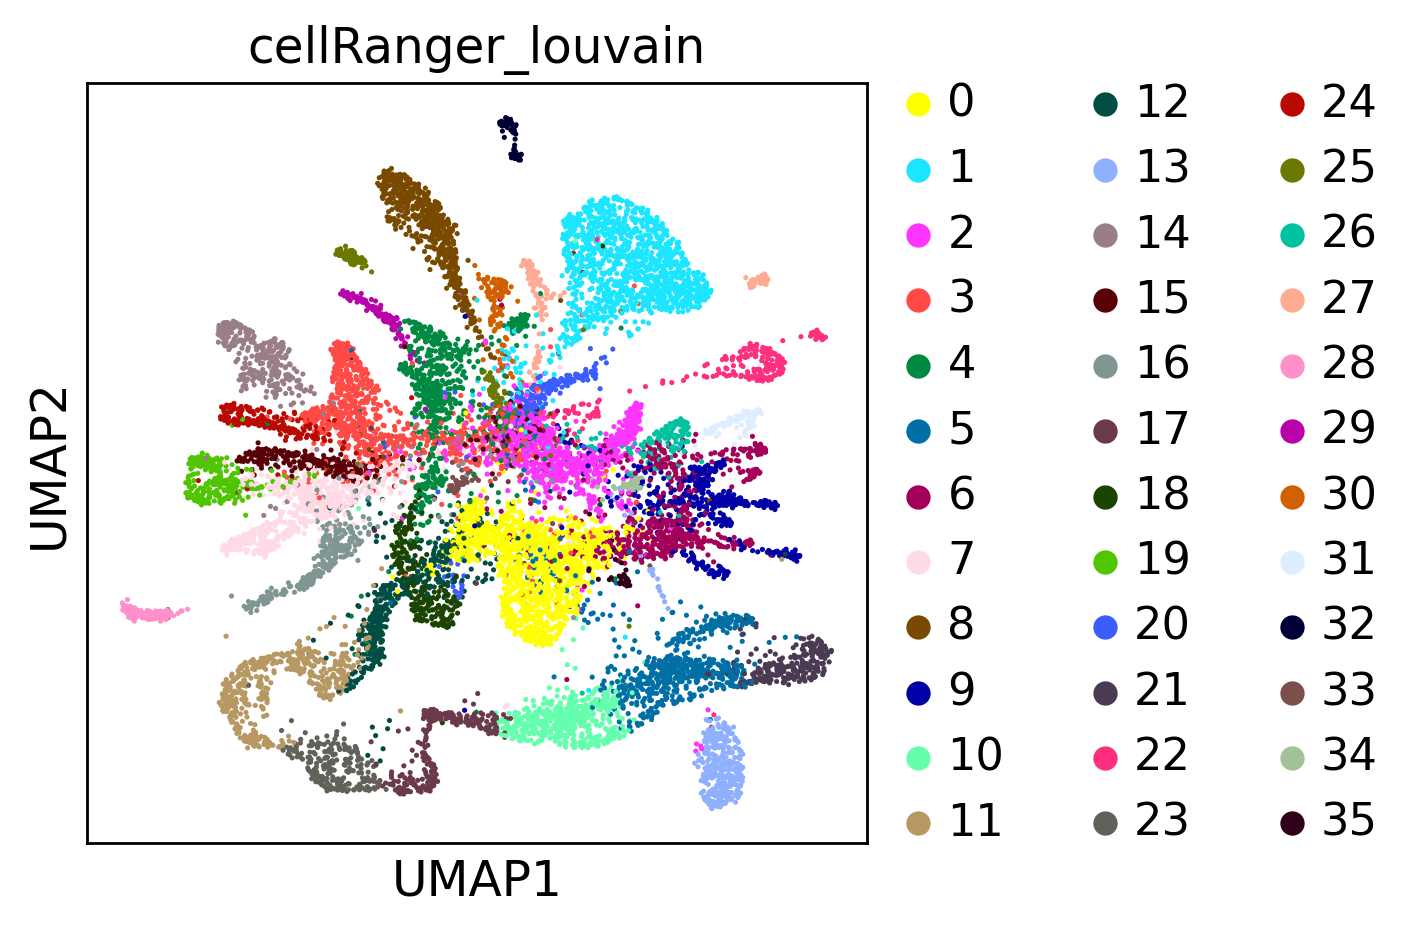

In [ ]:
sc.pl.umap(jelly_adata_filt,color=['cellRanger_louvain'])

#### **Plot Overlap in Cell Types**

In [ ]:
#Read in filtered and clustered MARIMBA data

jelly_adata_filt = anndata.read("D1.1833")

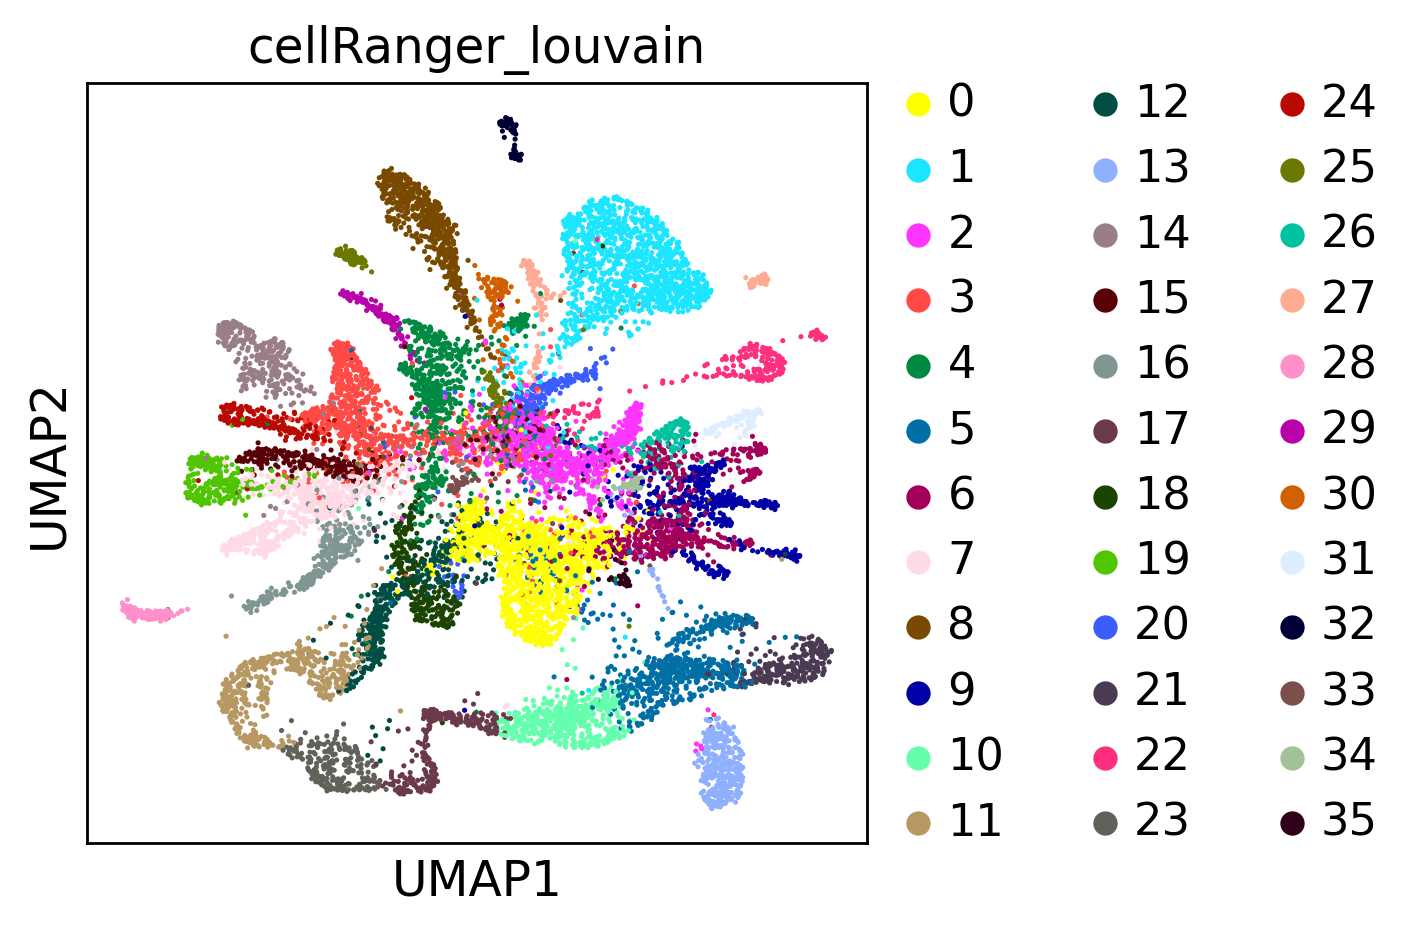

In [ ]:
sc.pl.umap(jelly_adata_filt,color=['cellRanger_louvain'])

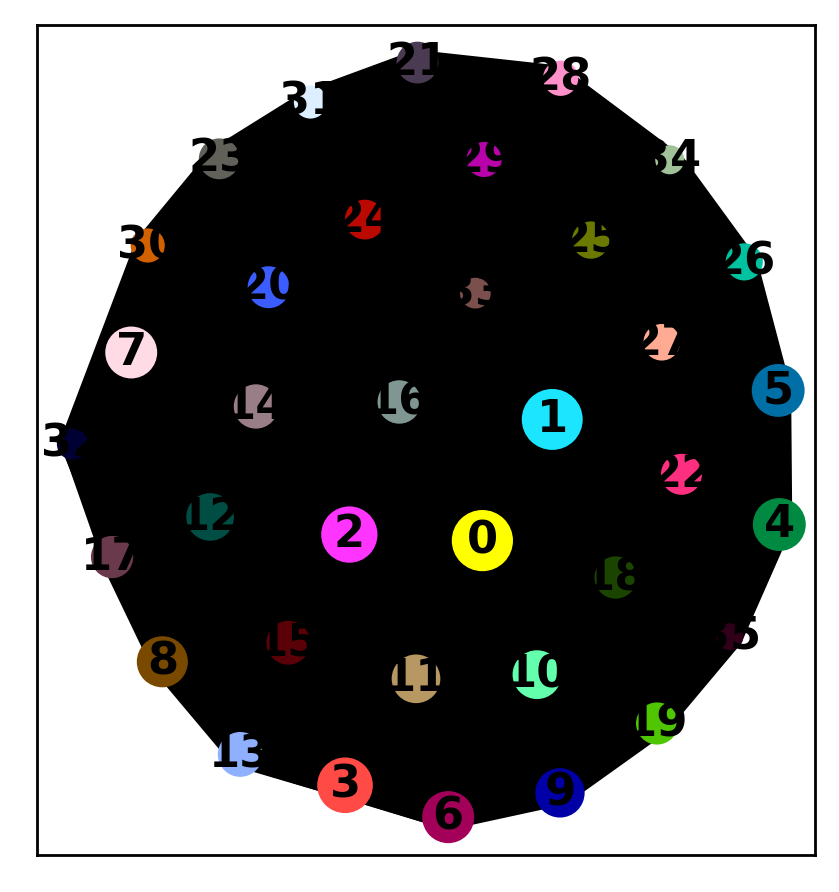

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


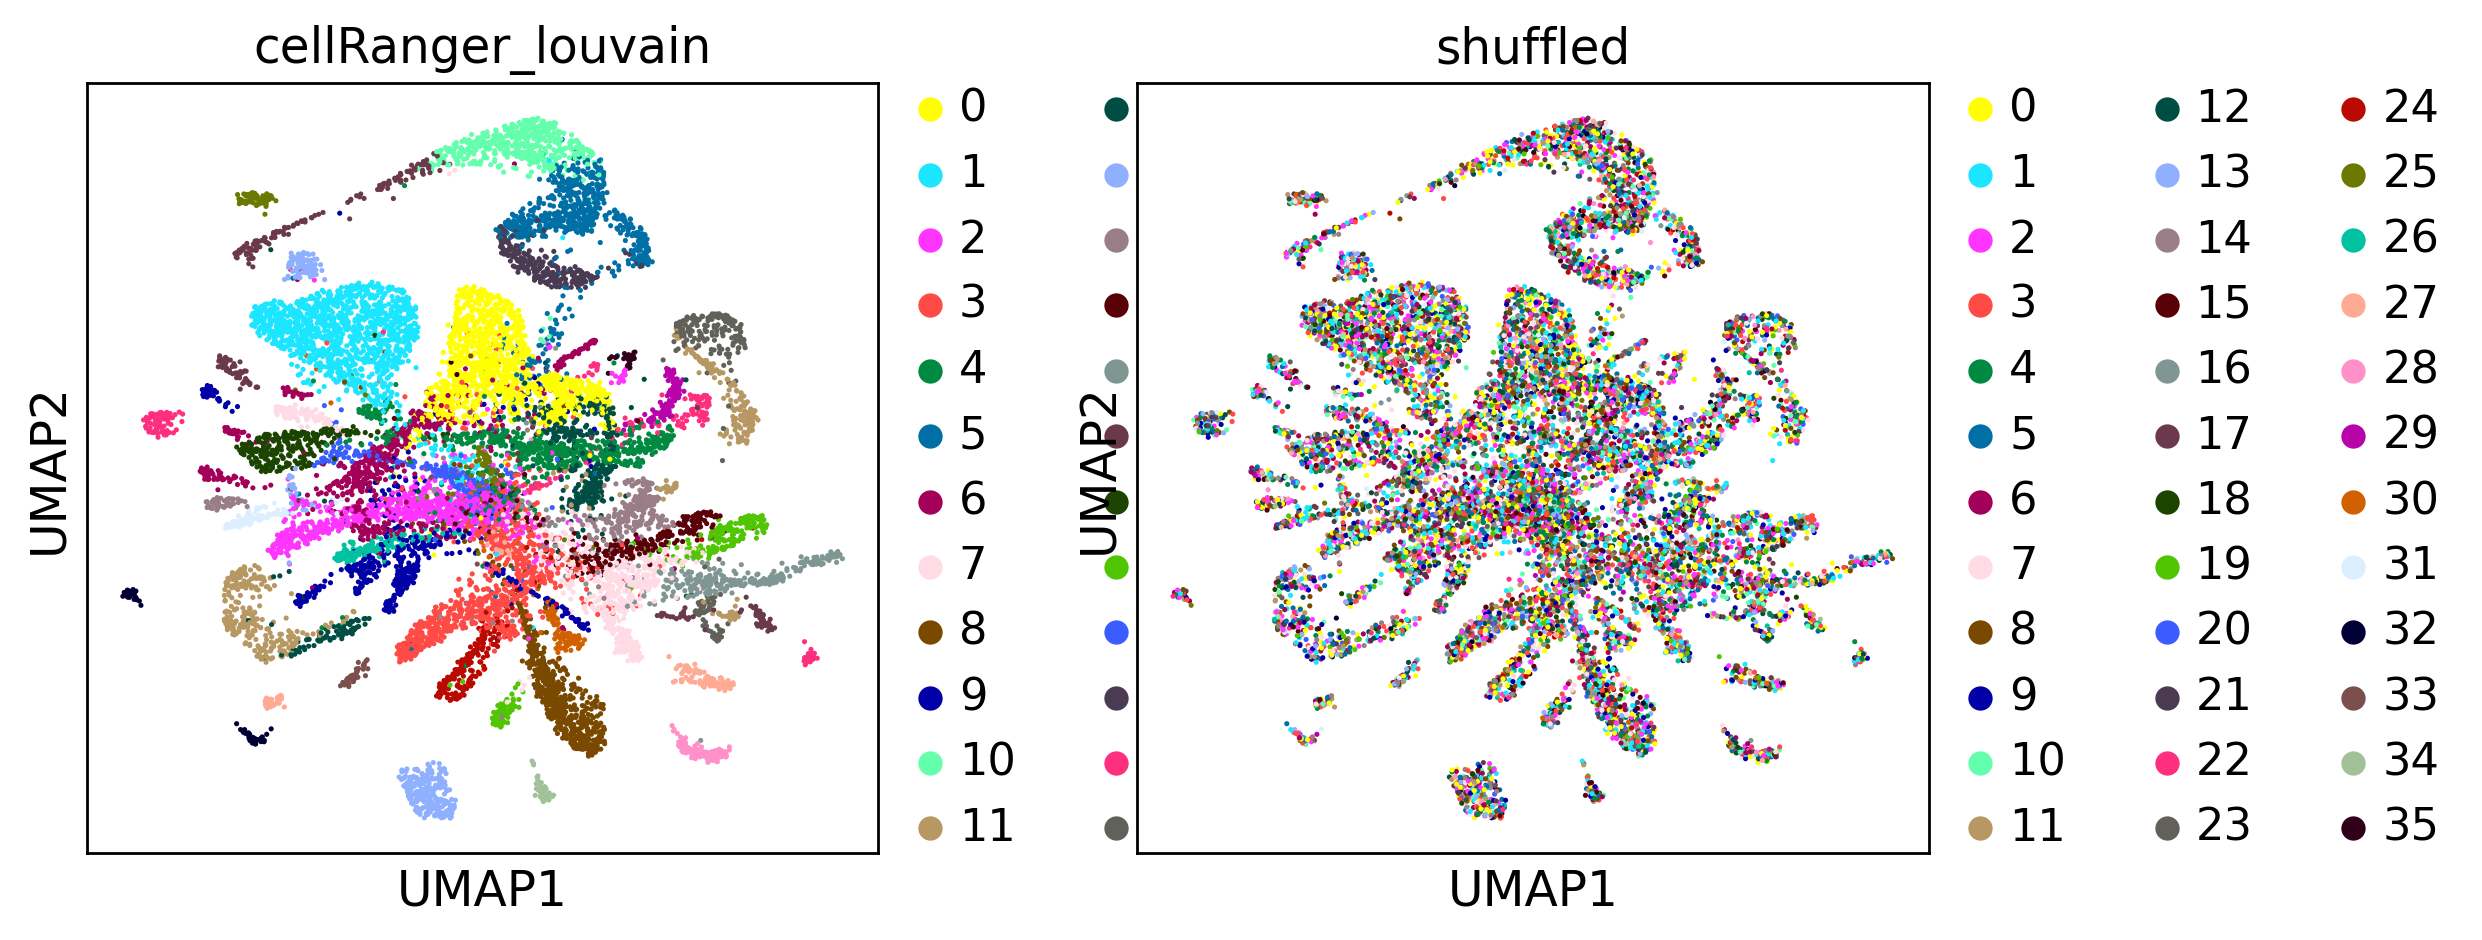

In [ ]:
#Check that embedding doesn't work with random cluster labels
import random
new_labels = list(jelly_adata_filt.obs['cellRanger_louvain'])
random.shuffle(new_labels)

jelly_adata_filt.obs['shuffled'] = pd.Categorical(new_labels)

sc.tl.paga(jelly_adata_filt, groups='shuffled',)
sc.pl.paga(jelly_adata_filt, color=['shuffled'])

sc.tl.umap(jelly_adata_filt,random_state=42,spread=3.5,min_dist = 1.5,init_pos='paga')

sc.pl.umap(jelly_adata_filt,color=['cellRanger_louvain','shuffled'])


In [ ]:
# len(set(jelly_adata_filt.var_names).intersection(bus_fs_trin.var_names))/len(jelly_adata_filt.var_names)


##### **Comparing Gene Markers**

In [ ]:
n=100
bus_fs_trin.obs['cellRanger_louvain'] = pd.Categorical(bus_fs_trin.obs['cellRanger_louvain'])
sc.tl.rank_genes_groups(jelly_adata_filt,groupby='cellRanger_louvain',n_genes=n,method='wilcoxon')
sc.tl.rank_genes_groups(bus_fs_trin,groupby='cellRanger_louvain',n_genes=n,method='wilcoxon')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Show pairwise overlap in top 100 names between all clusters, 36x36 grid
clus = np.unique(bus_fs_trin.obs['cellRanger_louvain'])

cuff = [[]]*len(clus) #np array of top 100 genes for each of 36 clusters
busFS = [[]]*len(clus)#np array of top 100 genes for each of 36 clusters

for c in clus:
  cuff[c] =  list(jelly_adata_filt.uns['rank_genes_groups']['names'][str(c)])
  busFS[c] = list(bus_fs_trin.uns['rank_genes_groups']['names'][str(c)])


In [ ]:
#https://stackoverflow.com/questions/52408910/python-pairwise-intersection-of-multiple-lists-then-sum-up-all-duplicates

In [ ]:
from itertools import combinations_with_replacement

#Changed to calculate Jaccard Index
def intersect(i,j):
  return len(set(cuff[i]).intersection(busFS[j]))/len(set(cuff[i]).union(busFS[j]))

def pairwise(clus):        
  # Initialise precomputed matrix (num of clusters, 36x36)
  precomputed = np.zeros((len(clus),len(clus)), dtype='float')
  # Initialise iterator over objects in X
  iterator = combinations_with_replacement(range(0,len(clus)), 2)
  # Perform the operation on each pair
  for i,j in iterator:
    precomputed[i,j] = intersect(i,j)          
  # Make symmetric and return
  return precomputed + precomputed.T - np.diag(np.diag(precomputed))


In [ ]:
pairCorrs = pairwise(clus)

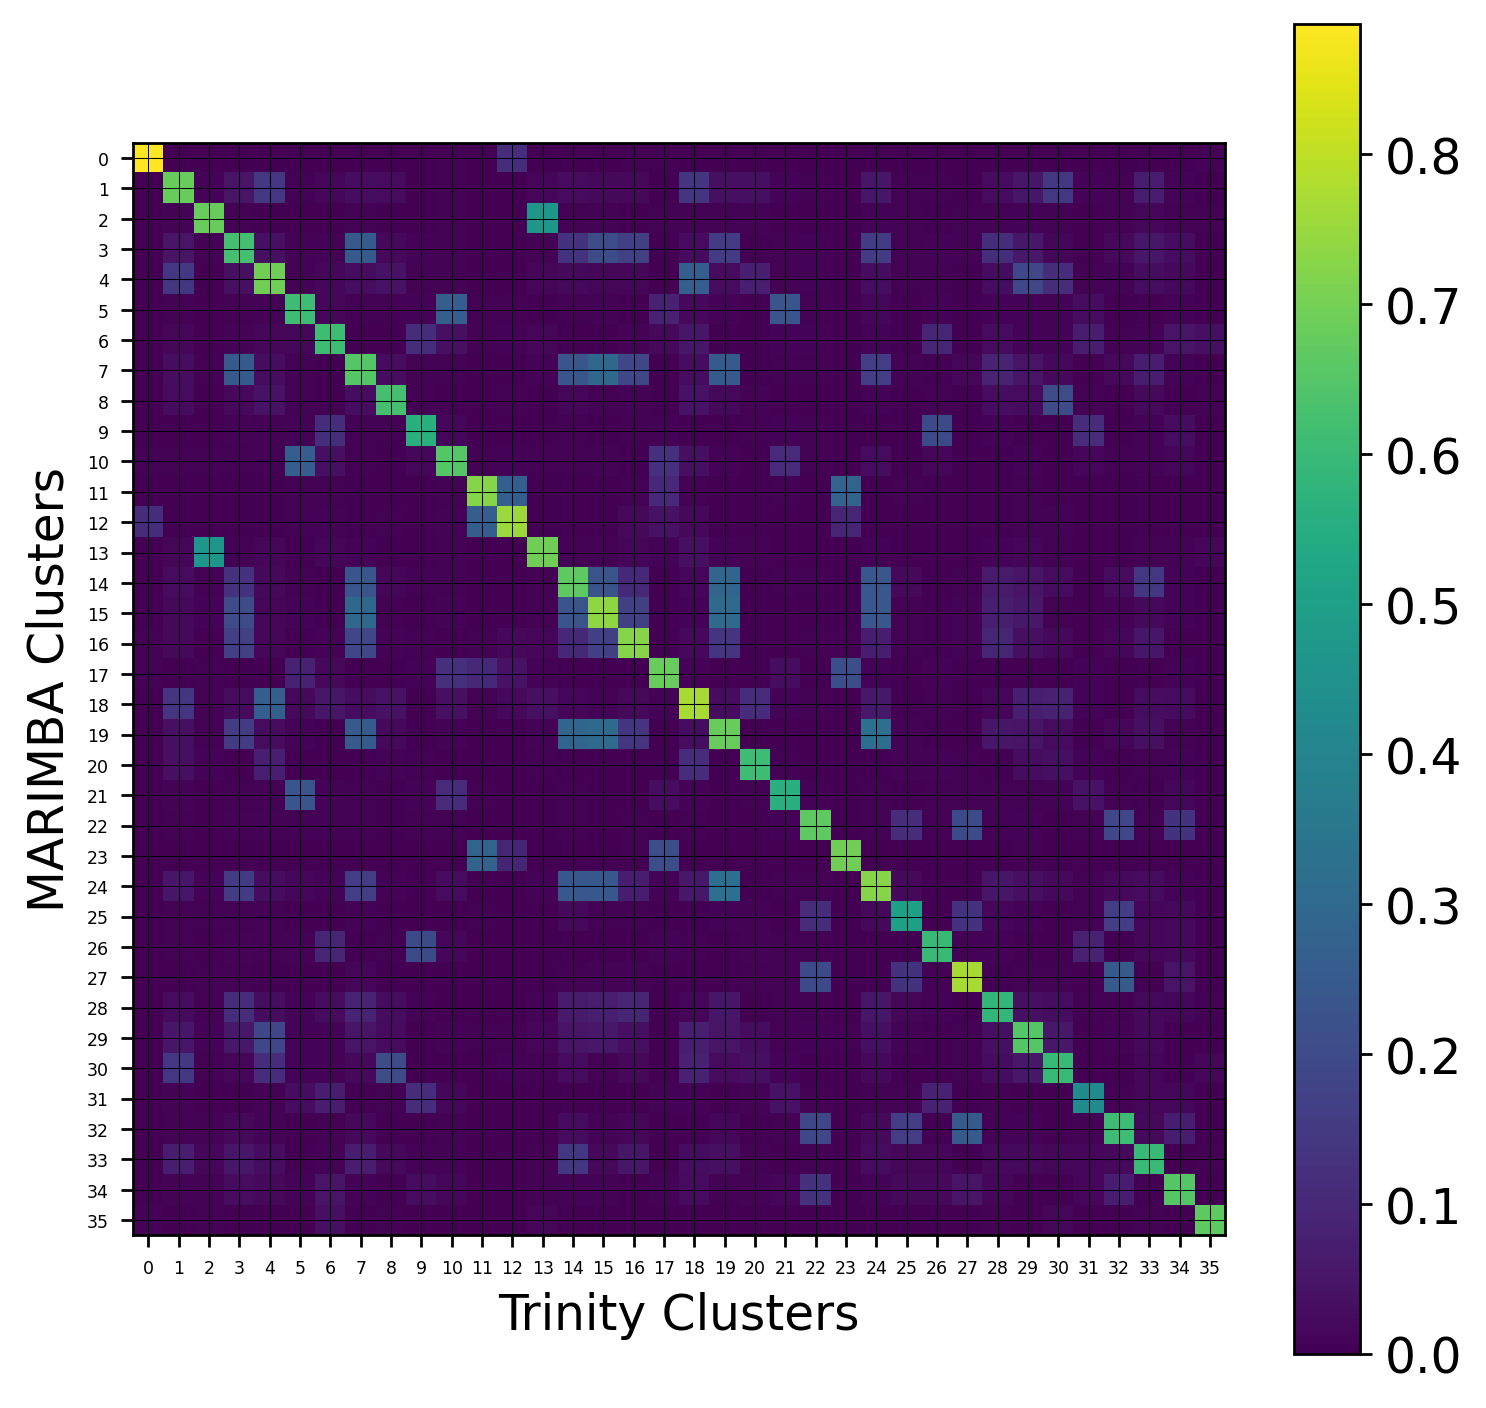

In [ ]:
plt.figure(figsize=(7,7))
plt.imshow(pairCorrs, cmap='viridis')
plt.colorbar()


plt.xticks(np.arange(0, 36, 1),fontsize=5)
plt.yticks(np.arange(0, 36, 1),fontsize=5)
plt.grid(color='black',linewidth=0.3)
plt.xlabel('Trinity Clusters')
plt.ylabel('MARIMBA Clusters')

plt.show()

In [ ]:
#jelly_adata_filt.write('cufflinks_clus_UMAP_PAGA.h5ad')

#### **Neuron Analysis**

In [ ]:
#Read in previously saved neurons (TRINITY) and filtered/clustered cufflinks data
neurons = anndata.read('D1.1804')

#Read in jelly_adata saved 

jelly_adata_filt = anndata.read('D1.1833')


jelly_adata_raw = anndata.read("D1.1832")
jelly_adata_raw = jelly_adata_raw[list(jelly_adata_filt.obs_names),:]

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [ ]:
jelly_adata_raw.obs['orgID'] = pd.Categorical(jelly_adata_filt.obs['orgID'])
jelly_adata_raw.obs['fed'] = pd.Categorical(jelly_adata_filt.obs['fed'])
jelly_adata_raw.obs['starved'] = pd.Categorical(jelly_adata_filt.obs['starved'])
jelly_adata_raw.obs['cellRanger_louvain'] = pd.Categorical(jelly_adata_filt.obs['cellRanger_louvain'])

Trying to set attribute `.obs` of view, copying.


/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.obs` of view, copying.
/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/usr/local/lib/python3.6/dist-packages/anndata/

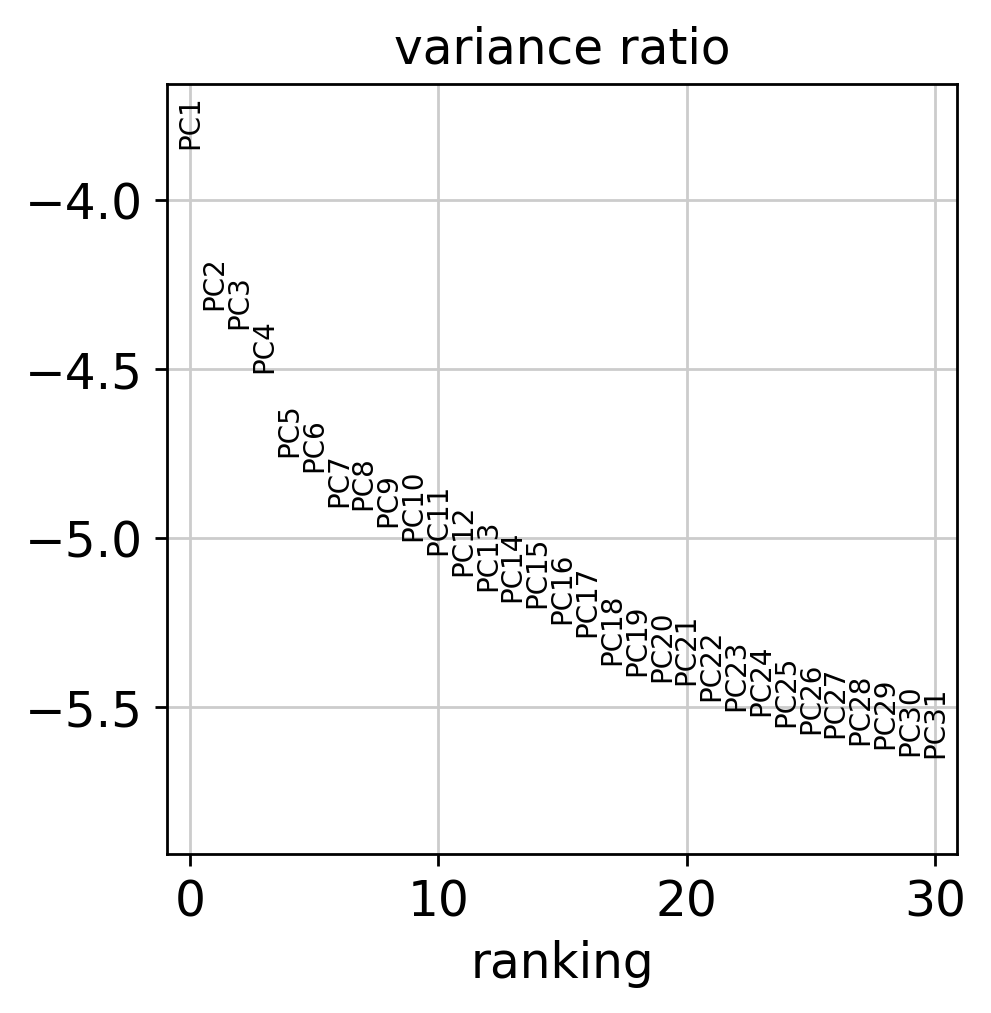

In [ ]:
cuff_neurons = jelly_adata_raw[jelly_adata_raw.obs['cellRanger_louvain'].isin([31,26,6,9])]
sc.pp.filter_cells(cuff_neurons, min_counts=0)
sc.pp.filter_genes(cuff_neurons, min_counts=0)

sc.pp.normalize_per_cell(cuff_neurons, counts_per_cell_after=1e4)

sc.pp.log1p(cuff_neurons)

# sc.pp.scale(raw_overlap_combo, max_value=10)
sc.pp.highly_variable_genes(cuff_neurons,n_top_genes=2000,n_bins=50)

#sc.pp.filter_cells(neurons, min_counts=0)
# sc.pp.filter_genes(neurons, min_counts=0)

# sc.pp.highly_variable_genes(neurons,n_top_genes=3000)
cuff_neurons = cuff_neurons[:,cuff_neurons.var['highly_variable']]

sc.pp.scale(cuff_neurons, max_value=10)

sc.tl.pca(cuff_neurons, n_comps=60)
sc.pl.pca_variance_ratio(cuff_neurons, log=True)

#applyNCAEmbed(neurons,neurons.obs['knn_clus'])

sc.pp.neighbors(cuff_neurons,n_neighbors=15, n_pcs=15) #n_neighbors=5, n_pcs=15,use_rep='X_nca'
sc.tl.louvain(cuff_neurons,resolution=1,key_added='louvain_neur',random_state=42)#Clustering algorithm,resolution=0.5

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.obs` of view, copying.


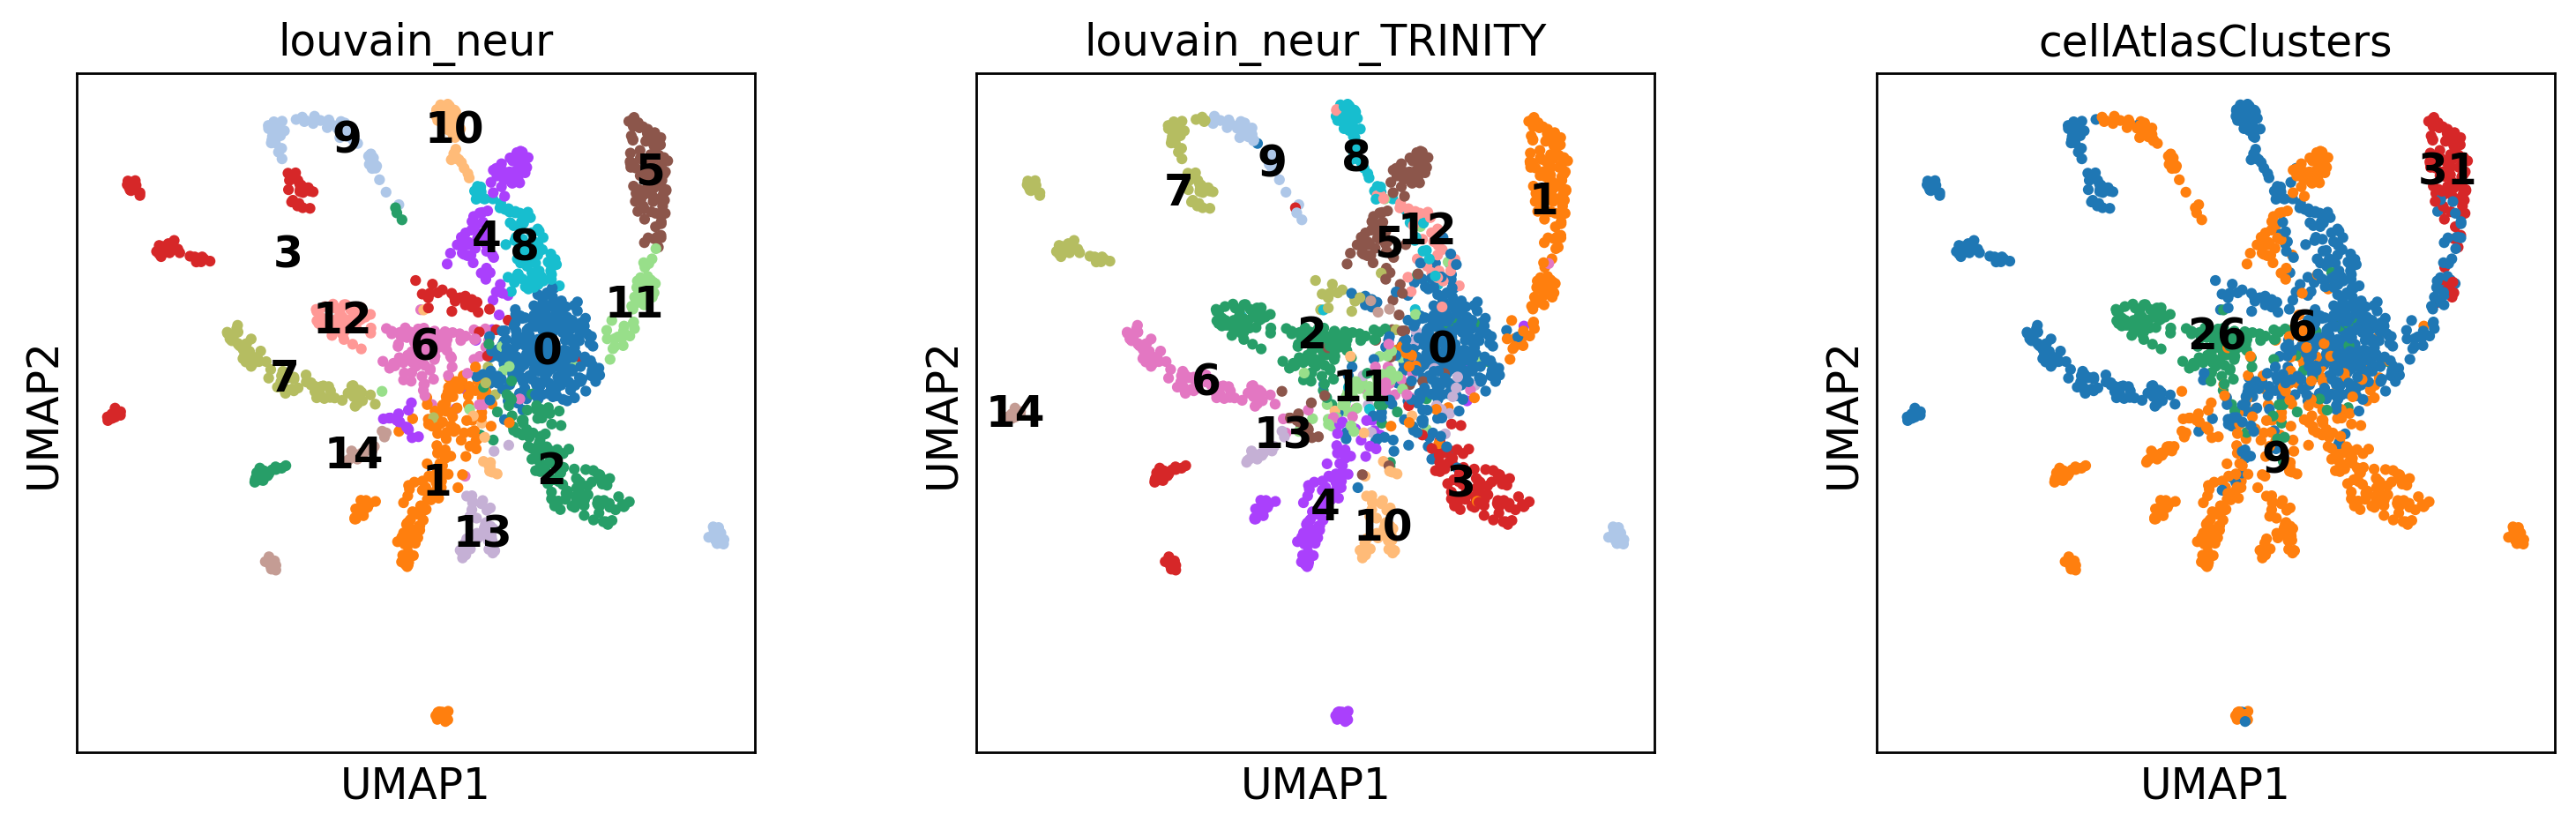

In [ ]:
sc.tl.louvain(cuff_neurons,resolution=0.95,key_added='louvain_neur',random_state=42)#Clustering algorithm,resolution=0.5
#sc.tl.tsne(neurons, n_pcs=15,perplexity=25,random_state = 42) #learning_rate=250
sc.tl.umap(cuff_neurons,random_state=42,spread=2.5, min_dist=1)

cuff_neurons.obs['cellAtlasClusters'] = pd.Categorical(cuff_neurons.obs['cellRanger_louvain'] )
cuff_neurons = cuff_neurons[neurons.obs_names,:]
cuff_neurons.obs['louvain_neur_TRINITY'] = neurons.obs['louvain_neur']

sc.pl.umap(cuff_neurons, color=['louvain_neur','louvain_neur_TRINITY','cellAtlasClusters'],color_map='viridis',size=50,legend_loc='on data')

In [ ]:
sc.tl.dendrogram(cuff_neurons,'louvain_neur',linkage_method='ward')
cuff_neurons.uns['dendrogram_louvain_neur'] = cuff_neurons.uns["dendrogram_['louvain_neur']"]
sc.tl.dendrogram(cuff_neurons,'louvain_neur_TRINITY',linkage_method='ward')
cuff_neurons.uns['dendrogram_louvain_neur_TRINITY'] = cuff_neurons.uns["dendrogram_['louvain_neur_TRINITY']"]

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.obs` of view, copying.
/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.var` of view, copying.
/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_

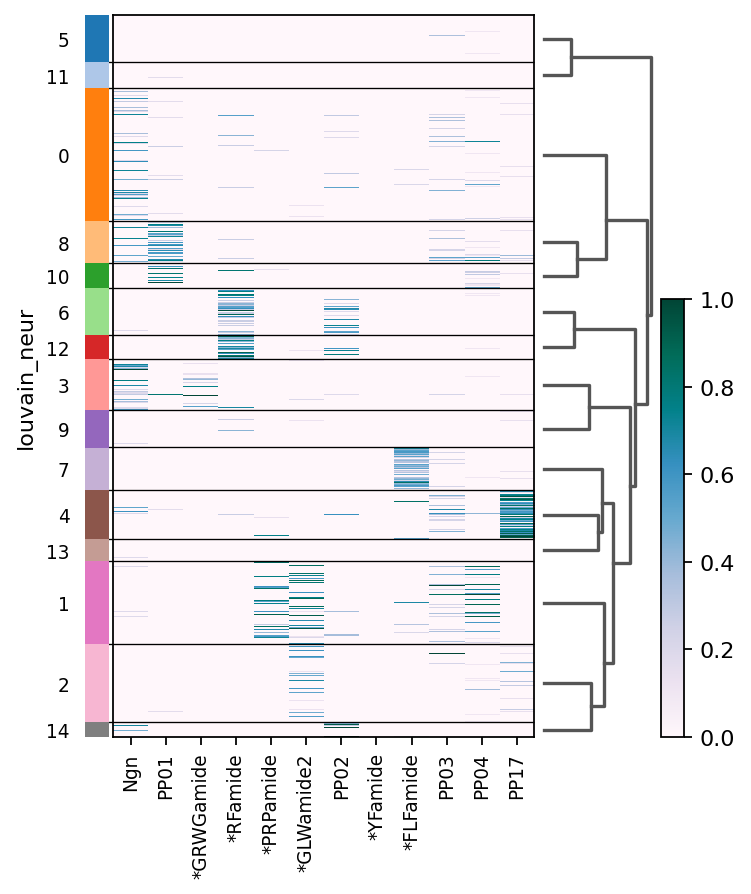

In [ ]:
#XLOC_042761 instead of TRINITY_DN20104_c0_g1_i1.mrna1
topGenes = ['XLOC_030920','XLOC_035224',
            'XLOC_040584','XLOC_019434','XLOC_042761','XLOC_017097',
            'XLOC_021799','XLOC_041402','XLOC_004021','XLOC_008730',
            'XLOC_014624','XLOC_030120']
forPlotAdata = jelly_adata_raw[jelly_adata_raw.obs['cellRanger_louvain'].isin([31,26,6,9])]
sc.pp.filter_cells(forPlotAdata, min_counts=0)
sc.pp.filter_genes(forPlotAdata, min_counts=0)

sc.pp.log1p(forPlotAdata)
forPlotAdata = forPlotAdata[cuff_neurons.obs_names,:]
forPlotAdata.obs['louvain_neur'] = cuff_neurons.obs['louvain_neur']
forPlotAdata.obs['louvain_neur_TRINITY'] = cuff_neurons.obs['louvain_neur_TRINITY']

forPlotAdata.uns['dendrogram_louvain_neur']  = cuff_neurons.uns['dendrogram_louvain_neur'] 
forPlotAdata.uns['dendrogram_louvain_neur_TRINITY']  = cuff_neurons.uns['dendrogram_louvain_neur_TRINITY'] 

neurons_sigTop = forPlotAdata[:,topGenes]

#labels = [allGenes[i] for i in forPlot]
labels = ['Ngn','PP01',
          '*GRWGamide','*RFamide','*PRPamide','*GLWamide2',
          'PP02','*YFamide','*FLFamide','PP03',
          'PP04','PP17']
neurons_sigTop.var['names'] = labels

sc.set_figure_params(scanpy=True, fontsize=10)
sc.pl.heatmap(neurons_sigTop, labels, groupby='louvain_neur', dendrogram=True,show_gene_labels=True,
              gene_symbols = 'names',swap_axes=False,
              cmap='PuBuGn',standard_scale='var',save='neuronMarkers.pdf') 

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


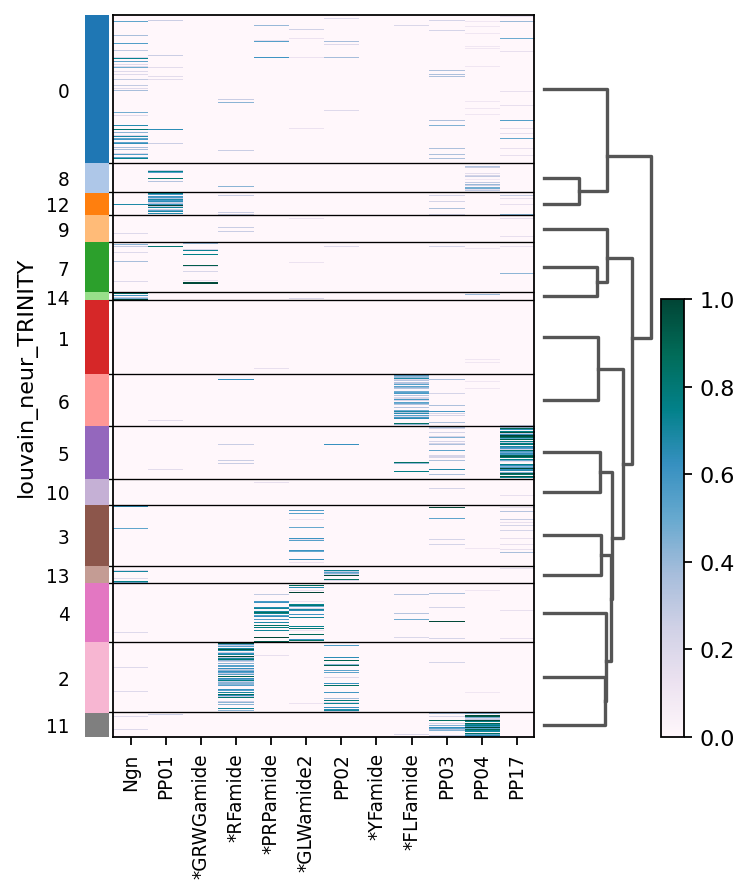

In [ ]:
sc.pl.heatmap(neurons_sigTop, labels, groupby='louvain_neur_TRINITY', dendrogram=True,show_gene_labels=True,
              gene_symbols = 'names',swap_axes=False,
              cmap='PuBuGn',standard_scale='var',save='neuronMarkers.pdf') 

In [ ]:
#Show pairwise overlap in top 100 names between all clusters, 36x36 grid
clus = np.unique(cuff_neurons.obs['louvain_neur'])

cuff = [[]]*len(clus) #np array of top 100 genes for each of 36 clusters
busFS = [[]]*len(clus)#np array of top 100 genes for each of 36 clusters

for c in clus:
  cuff[int(c)] =  list(cuff_neurons[cuff_neurons.obs['louvain_neur'].isin([c])].obs_names)
  busFS[int(c)] = list(cuff_neurons[cuff_neurons.obs['louvain_neur_TRINITY'].isin([c])].obs_names)

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [ ]:
pairCorrs = pairwise(clus)

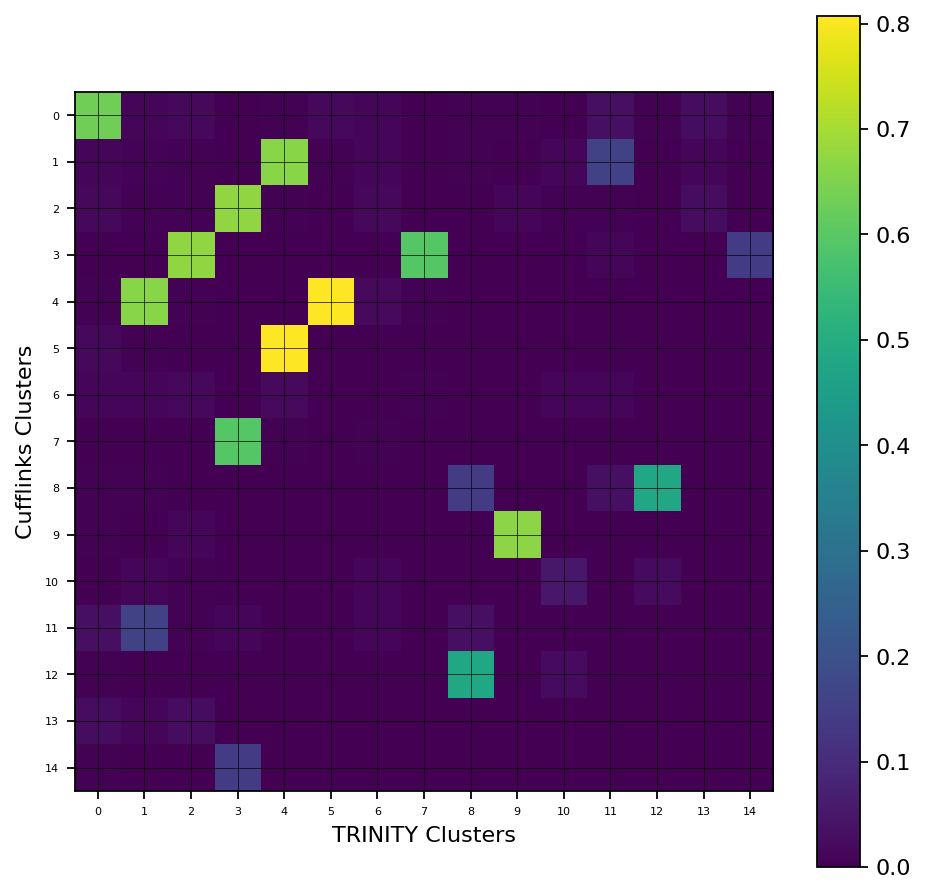

In [ ]:
plt.figure(figsize=(7,7))
plt.imshow(pairCorrs, cmap='viridis')
plt.colorbar()


plt.xticks(np.arange(0, len(clus), 1),fontsize=5)
plt.yticks(np.arange(0, len(clus), 1),fontsize=5)
plt.grid(color='black',linewidth=0.3)
plt.xlabel('TRINITY Clusters')
plt.ylabel('Cufflinks Clusters')

plt.show()

True

#####**Check if application of TRINITY Louvain clusters is appropriate**

In [ ]:
cuff_neurons = jelly_adata_filt[jelly_adata_filt.obs['cellRanger_louvain'].isin([31,26,6,9])]
cuff_neurons = cuff_neurons[neurons.obs_names,:]
cuff_neurons.obs['louvain_neur'] = neurons.obs['louvain_neur']

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Trying to set attribute `.obs` of view, copying.


In [ ]:
n=5
neurons.obs['louvain_neur'] = pd.Categorical(neurons.obs['louvain_neur'])
sc.tl.rank_genes_groups(cuff_neurons,groupby='louvain_neur',n_genes=n,method='wilcoxon')
sc.tl.rank_genes_groups(neurons,groupby='louvain_neur',n_genes=n,method='wilcoxon',)

/usr/local/lib/python3.6/dist-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]


In [ ]:
#Show pairwise overlap in top 100 names between all clusters, 36x36 grid
clus = np.unique(neurons.obs['louvain_neur'])

cuff = [[]]*len(clus) #np array of top 100 genes for each of 36 clusters
busFS = [[]]*len(clus)#np array of top 100 genes for each of 36 clusters

for c in clus:
  cuff[int(c)] =  list(cuff_neurons.uns['rank_genes_groups']['names'][str(c)])
  busFS[int(c)] = list(neurons.uns['rank_genes_groups']['names'][str(c)])


In [ ]:
pairCorrs = pairwise(clus)

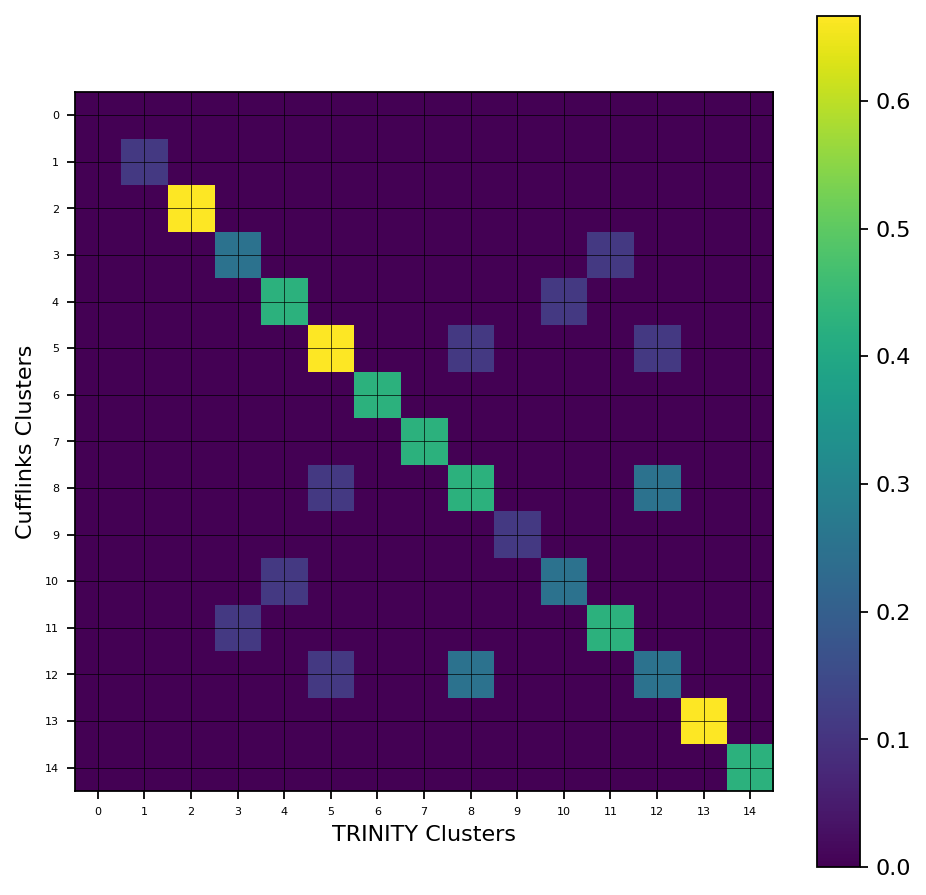

In [ ]:
plt.figure(figsize=(7,7))
plt.imshow(pairCorrs, cmap='viridis')
plt.colorbar()


plt.xticks(np.arange(0, len(clus), 1),fontsize=5)
plt.yticks(np.arange(0, len(clus), 1),fontsize=5)
plt.grid(color='black',linewidth=0.3)
plt.xlabel('TRINITY Clusters')
plt.ylabel('Cufflinks Clusters')

plt.show()

In [ ]:
neurons.uns['rank_genes_groups']['names']['0']

array(['XLOC_011074', 'XLOC_015355', 'XLOC_044603', 'XLOC_030920',
       'XLOC_004445'], dtype=object)

In [ ]:
cuff_neurons.uns['rank_genes_groups']['names']['0']

array(['XLOC_030930', 'XLOC_029992', 'XLOC_010444', 'XLOC_003896',
       'XLOC_006929'], dtype=object)